In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from hyperopt import fmin, tpe, hp, Trials
from tqdm import tqdm
from src.utils_py.auxil import *
from scipy.optimize import minimize

---

# Density profile generator

In [19]:
def density_profile(structure, sl, center=True):
    z, dz = np.linspace(-structure.box[2] / 2, structure.box[2] / 2, sl, retstep=True)
    rho = np.zeros(sl, dtype=int)
    z_c = np.mean(structure.atoms_xyz[:, 2]) if center else 0

    for i in range(structure.atoms_xyz.shape[0]):
        id = np.floor((structure.atoms_xyz[i, 2] - z_c + structure.box[2] / 2) / dz).astype(int)
        id = np.clip(id, 0, sl-1)
        rho[id] += 1

    dV = structure.box[0] * structure.box[1] * dz
    return z, rho.astype(np.float64) / dV

---

# Droplet approximation

In [43]:
phi = 0.5
file = 'synthetic/150/droplet/1.gro'
rho_bulk = 12

In [44]:
structure = read_gro(f'{file}')

l = structure.box[0] / structure.box[2]
H = structure.box[2]

z, dens = density_profile(structure, 200)

dens /= rho_bulk
zeta = z / H

rho_func = rho_perforation

In [45]:
np.trapz(dens, zeta)

0.49899999999999994

In [15]:
z_t = np.linspace(-0.5, 0.5, 1000, endpoint=True)
np.trapz(rho_perforation(z_t, l, phi, np.deg2rad(120)), z_t)

0.7992493162021372

In [46]:
rho_func = rho_roll

In [47]:
left, right = 0, len(zeta)
for i in range(len(zeta)):
    # if dens[i] > 0:
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    # if dens[i] > 0:
    if zeta[i] < 0.5:
        right = i+1
        break

def error_L1(args):
    return np.sum(np.abs(rho_func(zeta[left:right], l, phi, args['theta']) + args['offset'] - dens[left:right]))

def error_L2(args):
    return np.sum((rho_func(zeta[left:right], l, phi, args['theta']) + args['offset'] - dens[left:right])**2)

trials = Trials()

space = {
    'theta': hp.uniform('theta', np.pi/2, np.pi),
    'offset': hp.uniform('offset', -1, 1)
}

best = fmin(
    fn=error_L1,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials,
    show_progressbar=True
)

print('Best')
print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))

100%|██████████| 2000/2000 [00:09<00:00, 208.35trial/s, best loss: 12.779219751759275]
Best
angle: 168.3
offset: -0.00


NameError: name 'best' is not defined

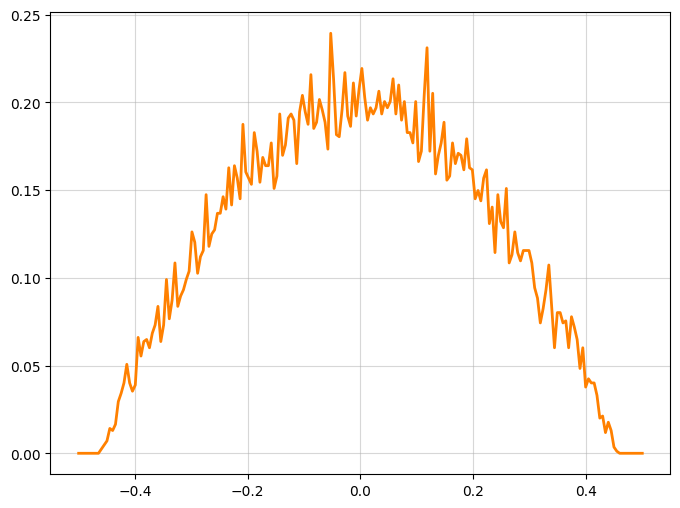

In [14]:
plt.figure(figsize=(8, 6))

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='points',
    color='#FF8000',
    linewidth=2
)

plt.plot(
    zeta, rho_func(zeta, l, phi, best['theta']) + best['offset'],
    # zeta, rho_func(zeta, l, phi, np.deg2rad(120)),
    label=r'approximation with $\theta$ = {}$^\circ$C'.format(int(np.rad2deg(best["theta"]))),
    # color='#00B400',
    color='#D2001B',
    linewidth=2,
    linestyle='dashed'
)

# plt.xlim(-0.9, 0.9)
# plt.ylim(-0.75, 0.75)
plt.xlabel('z', fontsize=16)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.ylim(bottom=-0.1)
plt.show()
# plt.savefig('img/density_profile_calcite_dodecane.eps')

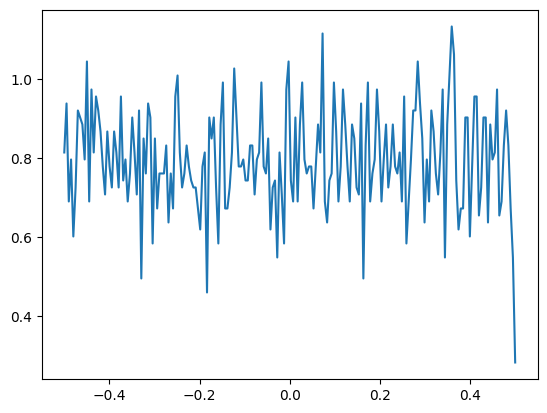

In [12]:
plt.plot(zeta, dens)

---

# Mean droplet approximation

In [16]:
types   = ['droplet', 'doughnut', 'worm', 'roll', 'perforation']
func    = [rho_droplet, rho_doughnut, rho_worm, rho_roll, rho_perforation]
phi     = np.array([0.1, 0.2, 0.3, 0.5, 0.8])
WIDTH_X = np.array([15 , 15 , 15 , 15 , 15 ])
WIDTH_Y = np.array([15 , 15 , 15 , 15 , 15 ])
H       = np.array([7.5, 7.5, 7.5, 5  , 7.5])
c  = H / 2
c[0] = 0
c[2] = 0
thetas    = [180, 170, 160, 150, 140, 130, 120, 110, 100, 90.1]
iterations = 100
rho_bulk = 12

In [8]:
angle_predict = np.zeros((len(types), len(thetas)))

In [9]:
angle_predict.shape

(5, 10)

In [10]:
for id, type in enumerate(types):
# for id, type in enumerate([types[3]]):
    # id = 3
    for t, th in enumerate(thetas):
    # for t, th in enumerate([thetas[0]]):
        dens = np.zeros(200)

        for i in range(iterations):
            structure = read_gro(f'synthetic/{th}/{type}/{i+1}.gro')

            l = structure.box[0] / structure.box[2]
            H = structure.box[2]

            z, d = density_profile(structure, 200)
            dens += d

        dens /= iterations
        dens /= rho_bulk
        zeta = z / H

        rho_func = func[id]

        left, right = 0, len(zeta)
        for i in range(len(zeta)):
            # if dens[i] > 0:
            if zeta[i] > -0.5:
                left = i-1
                break

        for i in range(len(zeta)-1, -1, -1):
            # if dens[i] > 0:
            if zeta[i] < 0.5:
                right = i+1
                break

        def L1(x, zeta, dens, l, phi, rho_func):
            return np.sum(np.abs(rho_func(zeta, l, phi, x[0]) + x[1] - dens))

        x0 = [3*np.pi/4, 0]
        res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi[id], rho_func), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
        best = {'theta': res.x[0], 'offset': res.x[1]}

        print(f'{type}\t{th}')
        print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
        print('offset:', '{:.2f}'.format(best['offset']))
        print()

        angle_predict[id, t] = np.rad2deg(best['theta'])

Optimization terminated successfully.
         Current function value: 0.510447
         Iterations: 21
         Function evaluations: 39
droplet	180
angle: 174.2
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.474474
         Iterations: 21
         Function evaluations: 39
droplet	170
angle: 174.2
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.455016
         Iterations: 29
         Function evaluations: 59
droplet	160
angle: 159.4
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.477847
         Iterations: 23
         Function evaluations: 50
droplet	150
angle: 150.5
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.483004
         Iterations: 23
         Function evaluations: 44
droplet	140
angle: 139.8
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.492066
         Iterations: 23
         Fu

/Users/alexey/Dev/CA_article/src/utils_py/auxil.py:77: RuntimeWarning: invalid value encountered in sqrt
  return 0.25 * sqrt(a + b + c + d) - e + f


Optimization terminated successfully.
         Current function value: 0.897449
         Iterations: 22
         Function evaluations: 41
doughnut	100
angle: 99.1
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.994280
         Iterations: 27
         Function evaluations: 48
doughnut	90.1
angle: 90.6
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.899207
         Iterations: 25
         Function evaluations: 47
worm	180
angle: 173.9
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.965983
         Iterations: 27
         Function evaluations: 48
worm	170
angle: 168.7
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.915330
         Iterations: 26
         Function evaluations: 52
worm	160
angle: 159.1
offset: 0.00

Optimization terminated successfully.
         Current function value: 0.911086
         Iterations: 22
         Function e

/Users/alexey/Dev/CA_article/src/utils_py/auxil.py:270: RuntimeWarning: invalid value encountered in sqrt
  return 0.25 * sqrt(a - b + c) + d


Optimization terminated successfully.
         Current function value: 2.072352
         Iterations: 25
         Function evaluations: 46
perforation	100
angle: 98.9
offset: 0.00

Optimization terminated successfully.
         Current function value: 2.218854
         Iterations: 25
         Function evaluations: 47
perforation	90.1
angle: 90.2
offset: 0.00



In [167]:
angle_predict

array([[174.23876953, 174.23876953, 159.41992815, 150.49165606,
        139.78646851, 129.56506348, 120.52441406, 109.71386719,
        100.53808594,  90.        ],
       [174.45794678, 169.66279221, 158.93568178, 149.92053223,
        140.04931641, 130.07263184, 120.0300293 , 110.60705566,
         99.1373291 ,  90.61743164],
       [173.8526001 , 168.74890137, 159.08507234, 149.22959089,
        138.96166992, 129.58525085, 119.34777832, 109.85211307,
        100.39416504,  90.        ],
       [175.24594116, 168.76647949, 159.07858756, 150.17095161,
        140.33605957, 130.53076172, 121.87902832, 111.11132812,
        100.70205688,  90.38671875],
       [180.        , 169.19494629, 159.97961426, 148.64501953,
        140.21672652, 130.39233398, 119.95092773, 109.64135742,
         98.94616699,  90.23181152]])

In [15]:
np.save('synthetic_angle_predicted', angle_predict)

In [169]:
angle_predict = angle_predict[:, ::-1]

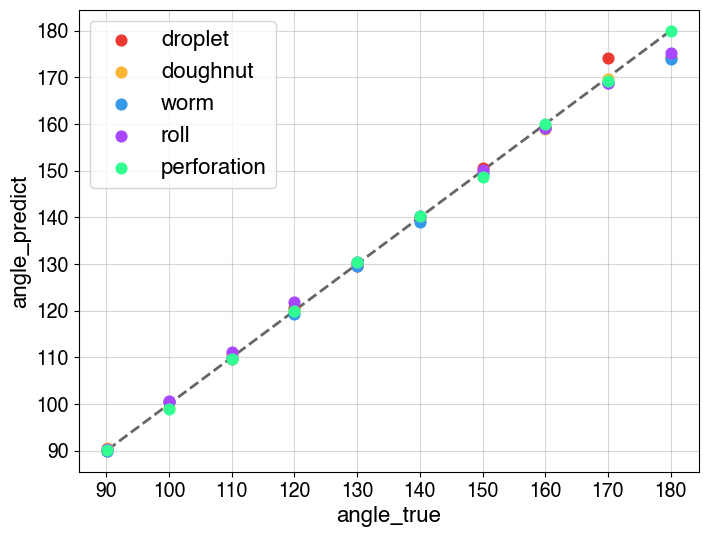

In [170]:
angle_true = np.array(thetas)
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]

plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5, zorder=0)
plt.plot(angle_true, angle_true, '--', lw=2, c='black', zorder=1, alpha=0.6)
for id, type in enumerate(types):
    plt.scatter(angle_true, angle_predict[id, ::-1], label=type, s=60, color=colors[id], zorder=2)

plt.legend(fontsize=16)
plt.xticks(np.arange(90, 181, 10, dtype=int), np.arange(90, 181, 10, dtype=int), fontsize=14)
plt.yticks(np.arange(90, 181, 10, dtype=int), np.arange(90, 181, 10, dtype=int), fontsize=14)
plt.xlabel('angle_true', fontsize=16)
plt.ylabel('angle_predict', fontsize=16)

plt.show()

In [184]:
angle_predict = angle_predict[:, ::-1]

In [185]:
# Расчет MAPE для cos
print('cos ', ('{:>.3f} | '*len(angle_true)).format(*np.abs(np.cos(np.deg2rad(angle_true)))), sep=' | ')
MAPE = np.mean(np.abs((np.cos(np.deg2rad(angle_predict)) - np.cos(np.deg2rad(angle_true))) / np.cos(np.deg2rad(angle_true))), axis=0)
print('MAPE |', ('{:>.3f} | '*len(MAPE)).format(*MAPE))

cos  | 1.000 | 0.985 | 0.940 | 0.866 | 0.766 | 0.643 | 0.500 | 0.342 | 0.174 | 0.002 | 
MAPE | 0.004 | 0.004 | 0.005 | 0.006 | 0.005 | 0.008 | 0.019 | 0.024 | 0.070 | 2.272 | 


In [186]:
print('angle,º', *angle_true, sep=' | ')
MAPE = np.mean(np.abs((angle_predict - angle_true) / angle_true), axis=0) * 100
print('MAPE, %|', ('{:>.2f} '*len(MAPE)).format(*MAPE))

angle,º | 180.0 | 170.0 | 160.0 | 150.0 | 140.0 | 130.0 | 120.0 | 110.0 | 100.0 | 90.1
MAPE, %| 2.47 0.93 0.44 0.38 0.26 0.28 0.52 0.46 0.71 0.25 


In [187]:
np.round(np.mean(np.abs((angle_predict - angle_true) / angle_true), axis=1) * 100, 1)

array([0.8, 0.6, 0.7, 0.8, 0.3])

In [166]:
np.abs((angle_predict - angle_true) / angle_true) * 100

array([[1.39260446, 1.14051533, 0.38269766, 1.11011025, 0.34121457,
        0.87657377, 0.68405647, 0.42526377, 0.25067238, 0.75714003],
       [0.0135549 , 1.39941115, 2.35647352, 2.62018197, 0.4283324 ,
        0.42973386, 0.47775166, 1.51896441, 0.69010403, 1.59933893],
       [0.09339136, 0.70825312, 1.60810222, 0.46677116, 1.02258599,
        0.6333034 , 0.67729227, 0.08141537, 1.59540279, 0.00619872],
       [6.12952066, 0.64968662, 2.94601742, 1.8823708 , 3.14590937,
        1.32057245, 0.16358598, 0.12536471, 0.7415567 , 3.5164309 ],
       [0.07775399, 0.09118454, 1.20439651, 0.29314749, 0.4297876 ,
        0.32253076, 1.13907204, 1.85288512, 0.41806753, 0.95481983]])

In [16]:
angle_true

array([180. , 170. , 160. , 150. , 140. , 130. , 120. , 110. , 100. ,
        90.1])

In [145]:
np.cos(np.deg2rad(angle_predict)) - np.cos(np.deg2rad(angle_true))

array([[ 0.97635759,  0.83079602,  0.60458582,  0.34602718,  0.12920669,
        -0.13684777, -0.35693273, -0.60166782, -0.80984082, -0.99797179],
       [ 0.99804152,  0.78716049,  0.64052061,  0.31927709,  0.11584246,
        -0.12996399, -0.35970407, -0.58232395, -0.8073978 , -0.99699267],
       [ 0.99972329,  0.7989996 ,  0.56882862,  0.35758314,  0.10565787,
        -0.13311155, -0.37475454, -0.59689245, -0.81827326, -0.99825465],
       [ 0.90202284,  0.80000407,  0.5450992 ,  0.33228034,  0.07026098,
        -0.14359573, -0.36815879, -0.59886408, -0.80710084, -0.99215885],
       [ 0.99947738,  0.81272709,  0.61949025,  0.36071775,  0.11581738,
        -0.11816734, -0.35073215, -0.61410387, -0.80892988, -0.99780481]])

In [126]:
len(MAPE)

5

Optimization terminated successfully.
         Current function value: 0.942180
         Iterations: 24
         Function evaluations: 47
worm	130
angle: 129.6
offset: 0.00



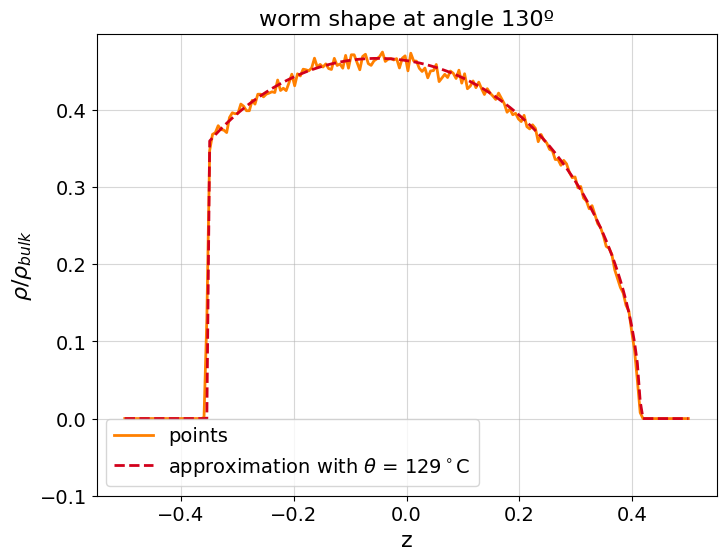

In [41]:
id = 2
type = types[id]
th = 130
dens = np.zeros(200)

for i in range(iterations):
    structure = read_gro(f'synthetic/{th}/{type}/{i+1}.gro')

    l = structure.box[0] / structure.box[2]
    H = structure.box[2]

    z, d = density_profile(structure, 200)
    dens += d

dens /= iterations
dens /= rho_bulk
zeta = z / H

rho_func = func[id]

left, right = 0, len(zeta)
for i in range(len(zeta)):
    # if dens[i] > 0:
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    # if dens[i] > 0:
    if zeta[i] < 0.5:
        right = i+1
        break

def L1(x, zeta, dens, l, phi, rho_func):
    return np.sum(np.abs(rho_func(zeta, l, phi, x[0]) + x[1] - dens))

x0 = [3*np.pi/4, 0]
res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi[id], rho_func), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
best = {'theta': res.x[0], 'offset': res.x[1]}

print(f'{type}\t{th}')
print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))
print()

plt.figure(figsize=(8, 6))
plt.title(f'{type} shape at angle {th}º', fontsize=16)

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='points',
    color='#FF8000',
    linewidth=2
)

plt.plot(
    zeta, rho_func(zeta, l, phi[id], best['theta']) + best['offset'],
    # zeta, rho_func(zeta, l, phi[0], np.pi),
    label=r'approximation with $\theta$ = {}$^\circ$C'.format(int(np.rad2deg(best["theta"]))),
    # color='#00B400',
    color='#D2001B',
    linewidth=2,
    linestyle='dashed'
)

# plt.xlim(-0.9, 0.9)
# plt.ylim(-0.75, 0.75)
plt.xlabel('z', fontsize=16)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.ylim(bottom=-0.1)
plt.show()
# plt.savefig('img/density_profile_calcite_dodecane.eps')

---

## Объединение графиков на одном

In [17]:
plt.rcParams['font.family'] = 'Helvetica'

In [20]:
id = 3
type = types[id]
th = 130
dens = np.zeros(200)

for i in range(iterations):
    structure = read_gro(f'synthetic/{th}/{type}/{i+1}.gro')

    l = structure.box[0] / structure.box[2]
    H = structure.box[2]

    z, d = density_profile(structure, 200)
    dens += d

dens /= iterations
dens /= rho_bulk
zeta = z / H

rho_func = func[id]

left, right = 0, len(zeta)
for i in range(len(zeta)):
    # if dens[i] > 0:
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    # if dens[i] > 0:
    if zeta[i] < 0.5:
        right = i+1
        break

def L1(x, zeta, dens, l, phi, rho_func):
    return np.sum(np.abs(rho_func(zeta, l, phi, x[0]) + x[1] - dens))

x0 = [3*np.pi/4, 0]
res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi[id], rho_func), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
best = {'theta': res.x[0], 'offset': res.x[1]}

print(f'{type}\t{th}')
print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))

Optimization terminated successfully.
         Current function value: 1.725116
         Iterations: 21
         Function evaluations: 36
roll	130
angle: 130.5
offset: 0.00


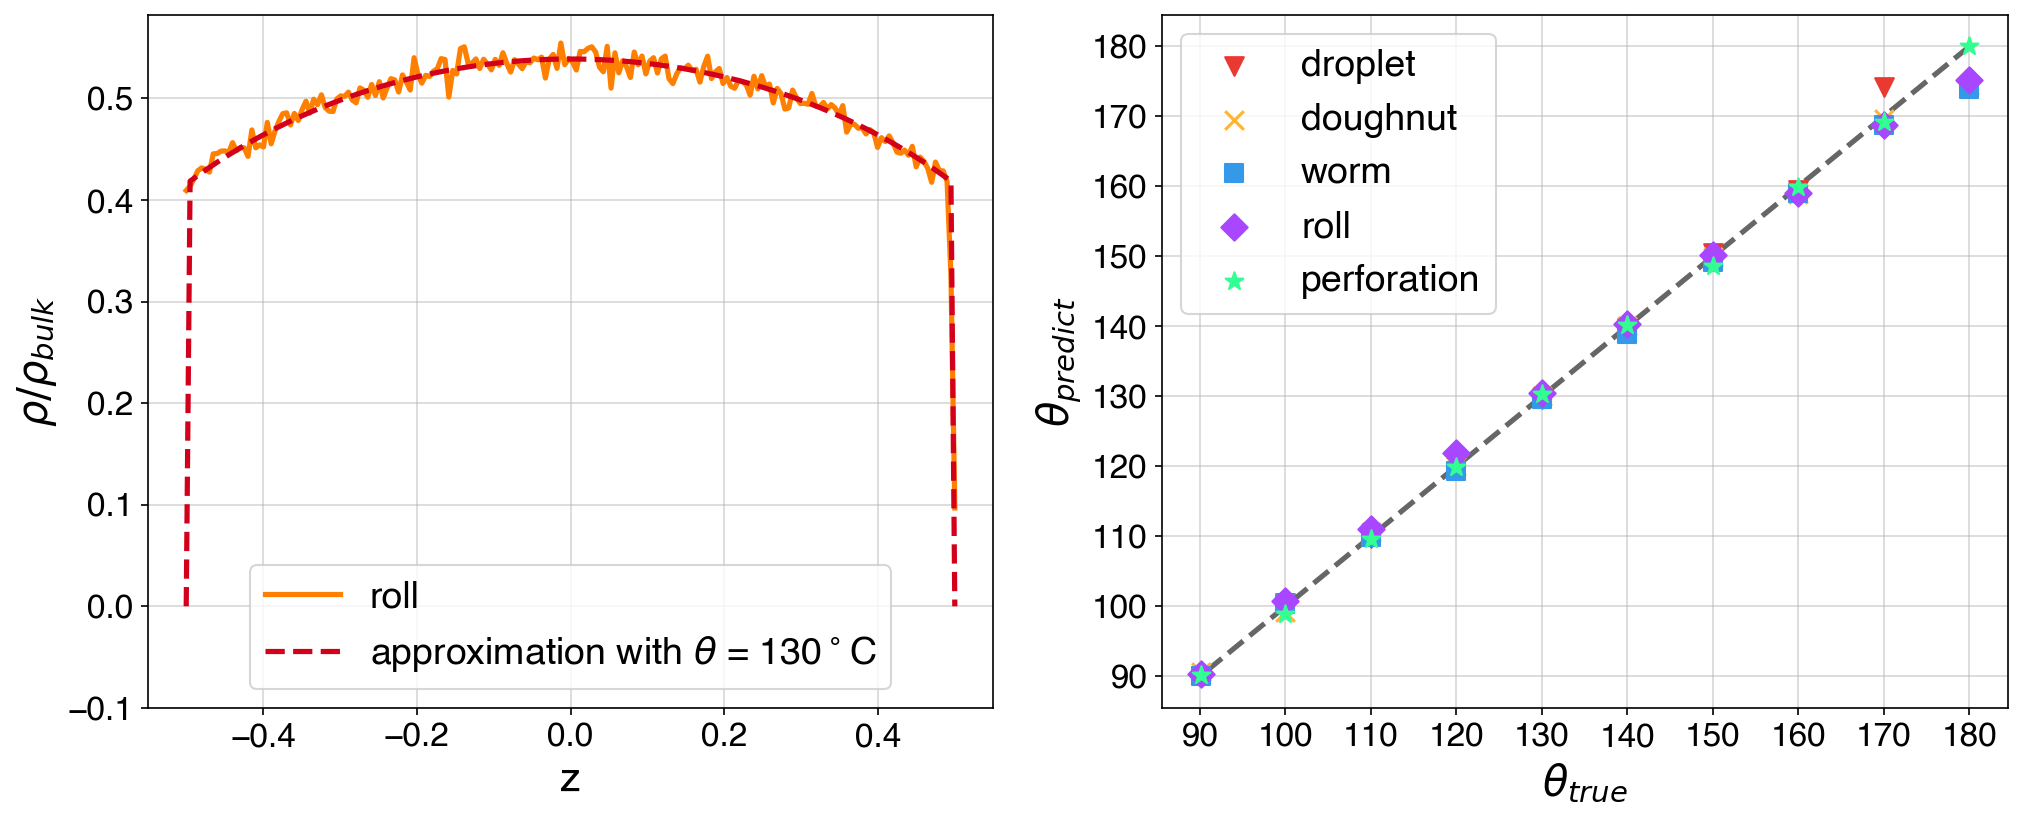

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Creating the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

# Plotting the first graph in the first subplot
ax1.grid(alpha=0.5)
ax1.plot(
    zeta, dens,
    label=type,
    color='#FF8000',
    linewidth=2.5
)
ax1.plot(
    zeta, rho_func(zeta, l, phi[id], best['theta']) + best['offset'],
    # zeta, rho_func(zeta, l, phi[0], np.pi),
    label=r'approximation with $\theta$ = {}$^\circ$C'.format(int(np.rad2deg(best["theta"]))),
    # color='#00B400',
    color='#D2001B',
    linewidth=2.5,
    linestyle='dashed'
)
# ax1.set_title(f'{type} shape at angle {th}º', fontsize=16)
ax1.set_xlabel('z', fontsize=20)
ax1.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
# ax1.legend(loc='best', fontsize=14)
ax1.legend(loc='lower center', fontsize=18)
ax1.set_ylim(bottom=-0.1)

angle_predict = np.load('synthetic_angle_predicted.npy')
angle_true = np.array(thetas)
colors = ["#ea3930", "#ffb534", "#3499e8", "#a946ff", "#32ff92", "#a9a9a9"]
markers = ['v', 'x', 's', 'D', '*']

# Plotting the second graph in the second subplot
ax2.grid(alpha=0.5, zorder=0)

ax2.plot(angle_true, angle_true, '--', lw=2.5, c='black', zorder=1, alpha=0.6)
for id_, type_ in enumerate(types):
    ax2.scatter(angle_true, angle_predict[id_, :], label=type_, s=80, marker=markers[id_], color=colors[id_], zorder=2)

ax2.legend(fontsize=18)
ax2.set_xticks(np.arange(90, 181, 10, dtype=int), np.arange(90, 181, 10, dtype=int), fontsize=16)
ax2.set_yticks(np.arange(90, 181, 10, dtype=int), np.arange(90, 181, 10, dtype=int), fontsize=16)
ax2.set_xlabel(r'$\theta_{true}$', fontsize=20)
ax2.set_ylabel(r'$\theta_{predict}$', fontsize=20)

# Adjust layout
# plt.tight_layout()
plt.show()


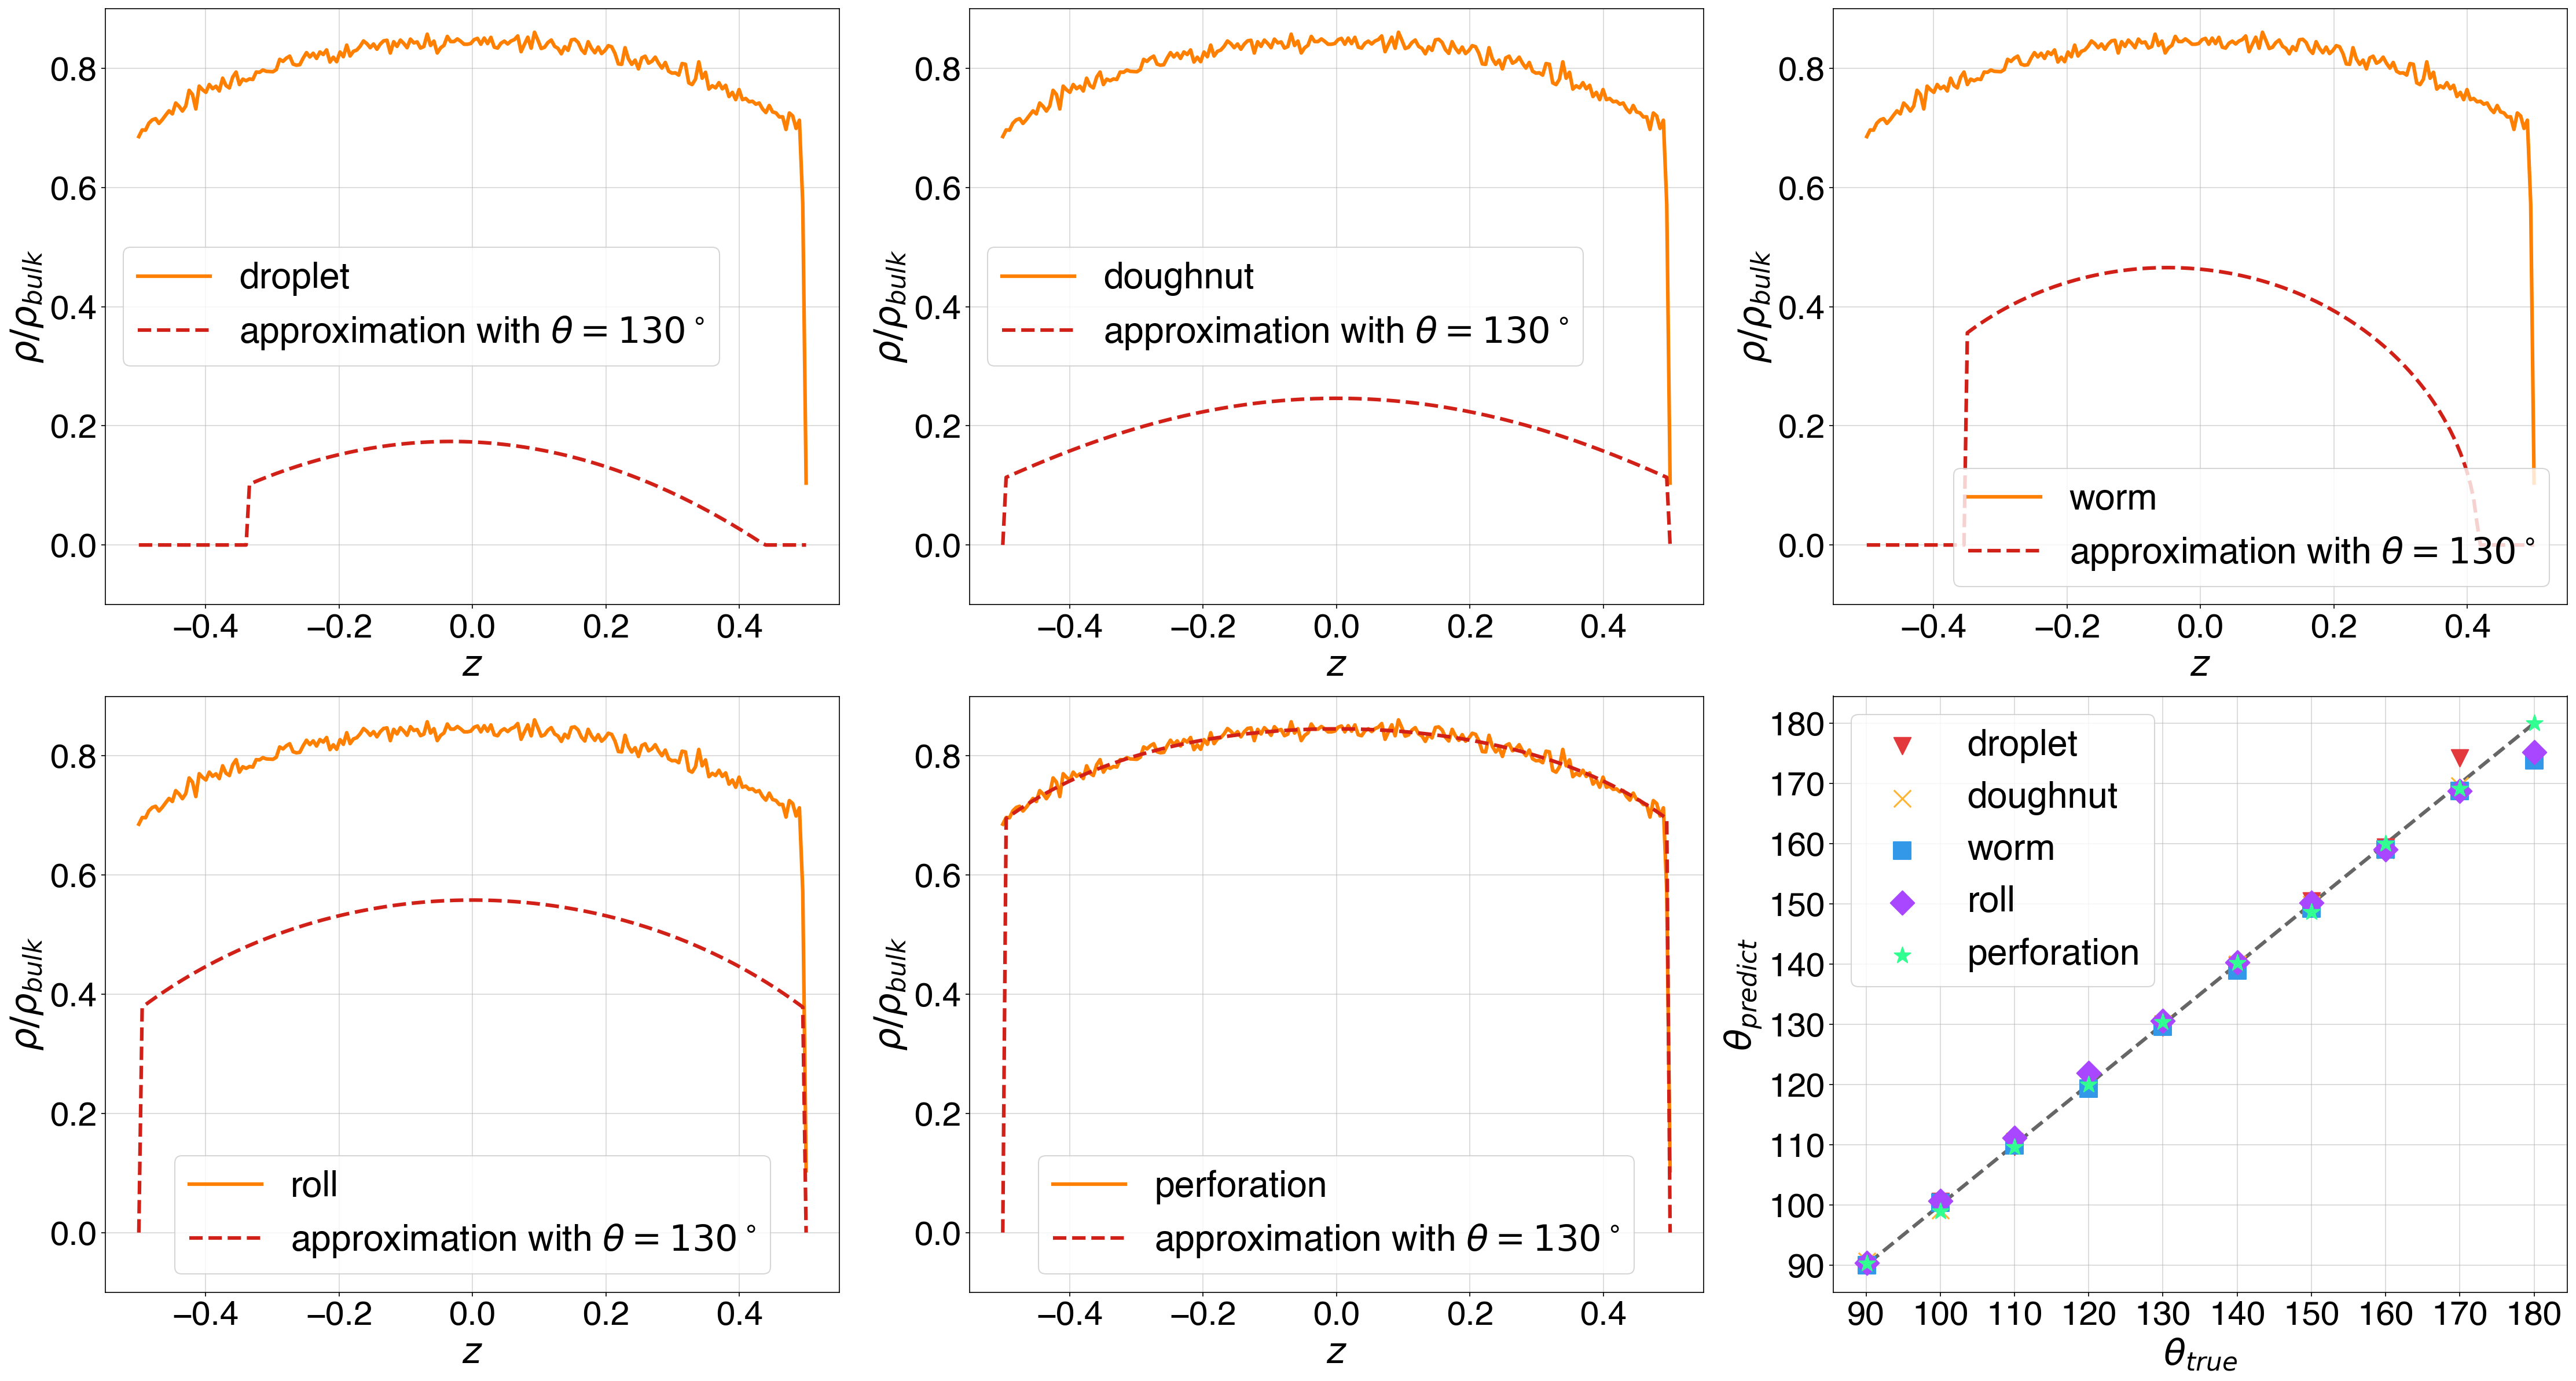

In [37]:
import matplotlib.pyplot as plt
import numpy as np

types = ["droplet", "doughnut", "worm", "roll", "perforation"]

label_font = 30
ticks_font = 28
legend_font = 30
lw=3
s=200

# Creating the figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(30, 16), dpi=150)

def get_density_profile(type, th, rho_func, phi):
    dens = np.zeros(200)

    for i in range(iterations):
        structure = read_gro(f'synthetic/{th}/{type}/{i+1}.gro')

        l = structure.box[0] / structure.box[2]
        H = structure.box[2]

        z, d = density_profile(structure, 200)
        dens += d

    dens /= iterations
    dens /= rho_bulk
    zeta = z / H

    left, right = 0, len(zeta)
    for i in range(len(zeta)):
        # if dens[i] > 0:
        if zeta[i] > -0.5:
            left = i-1
            break

    for i in range(len(zeta)-1, -1, -1):
        # if dens[i] > 0:
        if zeta[i] < 0.5:
            right = i+1
            break

    def L1(x, zeta, dens, l, phi, rho_func):
        return np.sum(np.abs(rho_func(zeta, l, phi, x[0]) + x[1] - dens))

    x0 = [3*np.pi/4, 0]
    res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi, rho_func), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
    best = {'theta': res.x[0], 'offset': res.x[1]}

    print(f'{type}\t{th}')
    print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
    print('offset:', '{:.2f}'.format(best['offset']))

    return l, zeta, dens, best

# Function to plot the density profile subplot
def plot_density_profile(ax, zeta, dens, rho_func, l, best_theta, best_offset, phi0, type):
    ax.grid(alpha=0.5)
    ax.plot(zeta, dens, label=type, color='#FF8000', linewidth=lw)
    ax.plot(zeta, rho_func(zeta, l, phi0, best_theta) + best_offset,
            label=r'approximation with $\theta = {}^\circ$'.format(int(np.rad2deg(best_theta))),
            color='#D02018', linewidth=lw, linestyle='dashed')
    ax.set_xlabel(r'$z$', fontsize=label_font)
    ax.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=label_font)
    ax.tick_params(axis='both', which='major', labelsize=ticks_font)
    # ax.legend(loc='lower center', fontsize=legend_font)
    ax.legend(loc='best', fontsize=legend_font)
    # ax.set_ylim(bottom=-0.1 * np.max(dens))
    ax.set_ylim(bottom=-0.1, top=0.9)

# Plot the first 5 subplots
id = 0
for i in range(2):
    for j in range(3):
        if i*3 + j < 5:
            # l, zeta, dens, best = get_density_profile(types[id], 130, func[id], phi[id])
            plot_density_profile(axs[i, j], zeta, dens, func[id],l, best['theta'], best['offset'], phi[id], types[id])
            id += 1

# Plotting the true-predict plot in the last subplot
angle_predict = np.load('synthetic_angle_predicted.npy')
angle_true = np.array(thetas)
colors = ["#e4393c", "#ffb534", "#3498e8", "#a946ff", "#32ff92", "#a9a9a9"]
markers = ['v', 'x', 's', 'D', '*', 'k']

ax = axs[1, 2]
ax.grid(alpha=0.5, zorder=0)
ax.plot(angle_true, angle_true, '--', lw=lw, c='black', zorder=1, alpha=0.6)
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for id_, type_ in enumerate(types):
    ax.scatter(angle_true, angle_predict[id_, :], label=type_, s=s, marker=markers[id_], color=colors[id_], zorder=2)

labels = ['a', 'b', 'c', 'd', 'e', 'f']
positions = [(0.3, 0.9),
             (0.3, 0.9),
             (0.3, 0.9),
             (0.3, 0.9),
             (0.3, 0.9),
             (0.3, 0.9)]

# for label, pos in zip(labels, positions):
#     plt.text(pos[0], pos[1], label, fontsize=34, ha='center', va='center', fontweight='bold', transform=fig.transFigure)

ax.legend(fontsize=legend_font)
ax.set_xticks(np.arange(90, 181, 10, dtype=int))
ax.set_yticks(np.arange(90, 181, 10, dtype=int))
ax.set_xticklabels(np.arange(90, 181, 10, dtype=int), fontsize=ticks_font)
ax.set_yticklabels(np.arange(90, 181, 10, dtype=int), fontsize=ticks_font)
ax.set_xlabel(r'$\theta_{true}$', fontsize=label_font)
ax.set_ylabel(r'$\theta_{predict}$', fontsize=label_font)

# Adjust layout
plt.tight_layout()
plt.show()

---

In [4]:
plt.rcParams['font.family'] = 'Helvetica'

In [5]:
structure = read_gro(f'cal_dw_1340_14458.gro')
# structure = read_gro(f'data/musc_dw_1289_13908.gro')

rho_bulk = 3.0896 * 10

H = 9.0
l = structure.box[0] / H
phi = 0.5
print('l:', l)
print('H:', H)

z, dens = np.loadtxt(f'data/dens_cal.xvg', comments=["@", "#"], unpack=True)

dens /= rho_bulk
zeta = z / H

print('real phi:', np.trapz(dens, zeta))

left, right = 0, len(zeta)
for i in range(len(zeta)):
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    if zeta[i] < 0.5:
        right = i+1
        break

def L1(x, zeta, dens, l, phi):
    return np.sum(np.abs(rho_roll(zeta, l, phi, x[0]) + x[1] - dens))

x0 = [3*np.pi/4, 0]
res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
best = {'theta': res.x[0], 'offset': res.x[1]}

print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))

l: 2.2227777777777775
H: 9.0
real phi: 0.4998787243386846
Optimization terminated successfully.
         Current function value: 12.686230
         Iterations: 20
         Function evaluations: 39
angle: 114.3
offset: 0.00


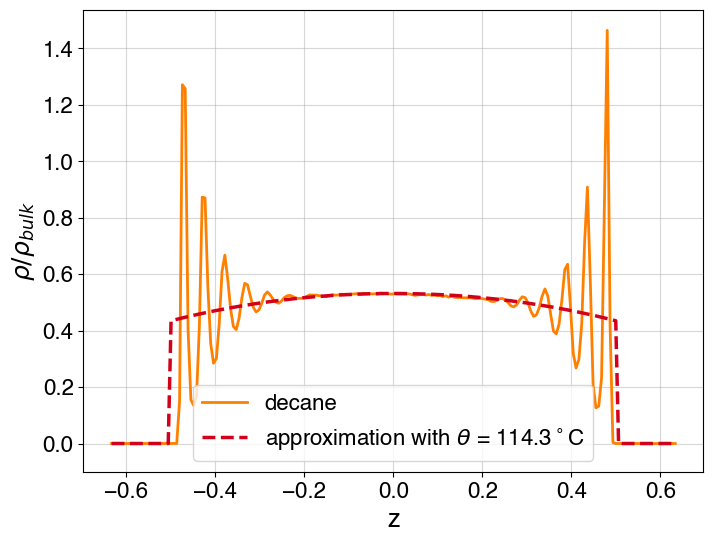

In [13]:
plt.figure(figsize=(8, 6))

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='decane',
    color='#FF8000',
    # color='#40BFBF',
    linewidth=2
)

plt.plot(
    zeta, rho_roll(zeta, l, phi, best['theta']) + best['offset'],
    label=r'approximation with $\theta$ = {:.1f}$^\circ$C'.format(np.rad2deg(best["theta"])),
    # color='#00B400',
    color='#D2001B',
    linewidth=2.5,
    linestyle='dashed'
)

plt.xlabel('z', fontsize=18)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower center', fontsize=16)
plt.ylim(bottom=-0.1)
# plt.savefig('img/density_profile_calcite_decane.png')
plt.show()

In [40]:
N = 5
T = 20000

l: 2.2227777777777775
H: 9.0
Optimization terminated successfully.
         Current function value: 5.127857
         Iterations: 20
         Function evaluations: 38
angle: 150.0
offset: 0.00


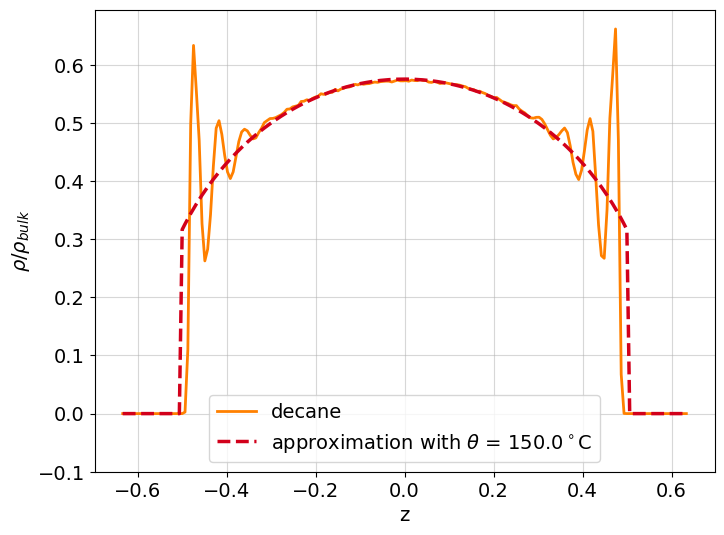

Optimization terminated successfully.
         Current function value: 3.105556
         Iterations: 7
         Function evaluations: 12
angle: 180.0
offset: 0.00


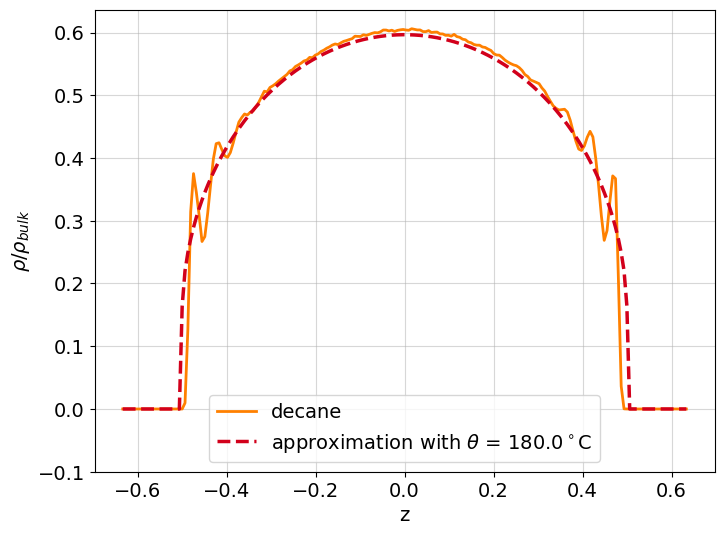

Optimization terminated successfully.
         Current function value: 4.211756
         Iterations: 7
         Function evaluations: 12
angle: 180.0
offset: 0.00


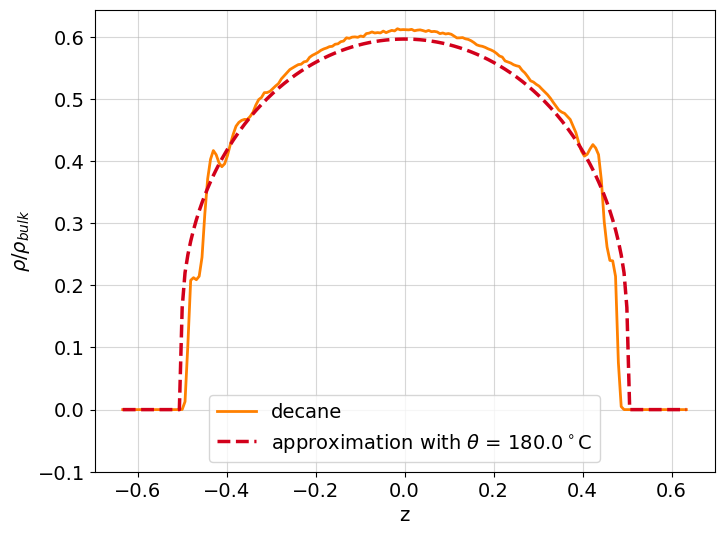

Optimization terminated successfully.
         Current function value: 5.612041
         Iterations: 7
         Function evaluations: 12
angle: 180.0
offset: 0.00


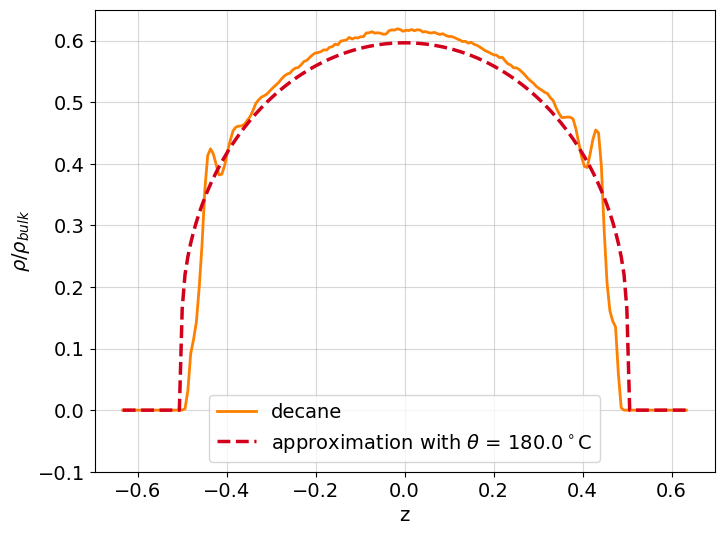

Optimization terminated successfully.
         Current function value: 6.817592
         Iterations: 7
         Function evaluations: 12
angle: 180.0
offset: 0.00


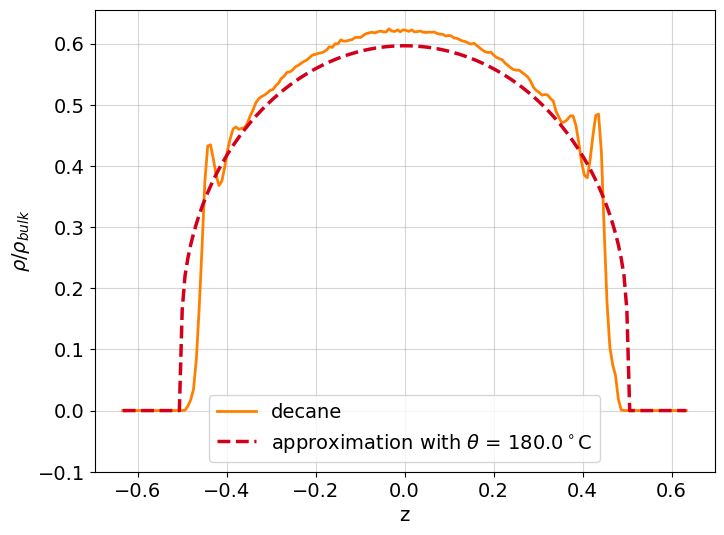

In [41]:
structure = read_gro(f'data/cal_dw_1340_14458.gro')

rho_bulk = 3.0896 * 10

H = 9.0
l = structure.box[0] / H
phi = 0.5
print('l:', l)
print('H:', H)

angles = []

for i in range(N):
    z, dens = np.loadtxt(f'data/dens_new/dens_{i}.xvg', comments=["@", "#"], unpack=True)

    dens /= rho_bulk
    zeta = z / H

    left, right = 0, len(zeta)
    for i in range(len(zeta)):
        if zeta[i] > -0.5:
            left = i-1
            break

    for i in range(len(zeta)-1, -1, -1):
        if zeta[i] < 0.5:
            right = i+1
            break

    def L1(x, zeta, dens, l, phi):
        return np.sum(np.abs(rho_roll(zeta, l, phi, x[0]) + x[1] - dens))

    x0 = [3*np.pi/4, 0]
    res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
    best = {'theta': res.x[0], 'offset': res.x[1]}

    print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
    print('offset:', '{:.2f}'.format(best['offset']))

    angles.append(np.rad2deg(best['theta']))

    plt.figure(figsize=(8, 6))

    plt.grid(alpha=0.5)
    plt.plot(
        zeta, dens,
        label='decane',
        color='#FF8000',
        # color='#40BFBF',
        linewidth=2
    )

    plt.plot(
        zeta, rho_roll(zeta, l, phi, best['theta']) + best['offset'],
        label=r'approximation with $\theta$ = {:.1f}$^\circ$C'.format(np.rad2deg(best["theta"])),
        # color='#00B400',
        color='#D2001B',
        linewidth=2.5,
        linestyle='dashed'
    )

    # plt.xlim(-0.9, 0.9)
    # plt.ylim(-0.75, 0.75)
    plt.xlabel('z', fontsize=14)
    plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='lower center', fontsize=14)
    plt.ylim(bottom=-0.1)
    plt.show()
    # plt.savefig('img/density_profile_calcite_dodecane.eps')

In [34]:
time = [T / 1000 / N * i + 5 for i in range(N)]

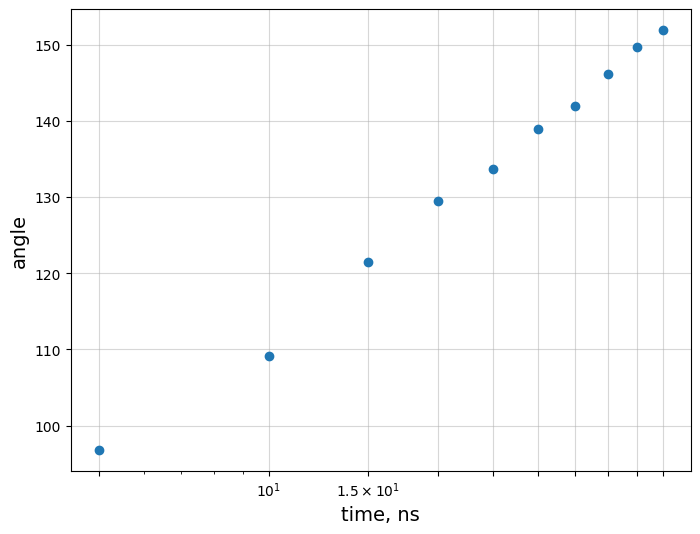

In [39]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5, zorder=1)

x_ticks = [T / 1000 / N * i + 5 for i in range(N)]

time = (np.array(time))
angles = (np.array(angles))

plt.scatter(time, angles, zorder=2)

plt.xscale('log')
plt.xlabel('time, ns', fontsize=14)
plt.ylabel('angle', fontsize=14)
plt.xticks(x_ticks)

plt.show()

In [42]:
x = 1
try:
    x += '1'
except:
    print('lol')

SyntaxError: invalid syntax (861095605.py, line 4)

In [40]:
x

1